**FAST (Features from Accelerated Segment Test)**

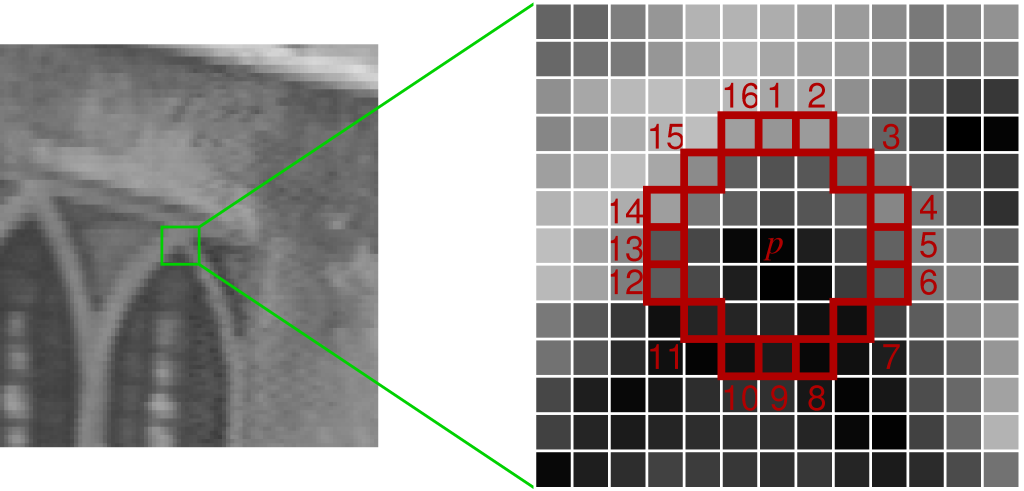<!-- .element height="25%" width="25%" -->

Finding keypoints with FAST9...
Keypoints shown in green in image
Sorting and printing keypoints with top Harris measure...
Top Harris measure keypoints shown in red in image
Finding orientation of keypoints...
Finding keypoints with FAST9...
Keypoints shown in green in image
Sorting and printing keypoints with top Harris measure...
Top Harris measure keypoints shown in red in image
Finding orientation of keypoints...
Finding keypoints with FAST9...
Keypoints shown in green in image
Sorting and printing keypoints with top Harris measure...
Top Harris measure keypoints shown in red in image
Finding orientation of keypoints...


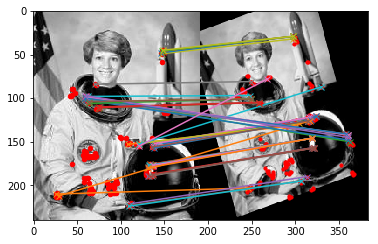

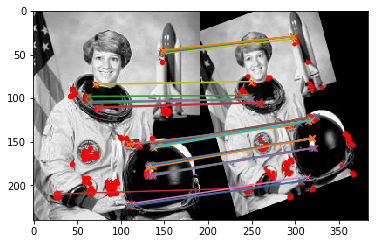

In [12]:
%matplotlib inline
import numpy as np
import random
import os
import sys
sys.path.append('/Library/Frameworks/Python.framework/\
Versions/2.7/lib/python2.7/site-packages')
from skimage import transform as tf
from sklearn.svm import LinearSVC
import matplotlib.pyplot as plt
import scipy.ndimage
from scipy.stats import truncnorm
from imageio import imread
from imageio import imwrite
from ofast9 import *
from proj_utils import *
from BRIEF import *

'''
rBRIEF: : Rotation-Aware Brief
Arguments:
    S: Set of pairs on pixel locations used to calculate BRIEF descriptor
    theta: Orientation of the keypoint 
Returns: rBRIEF, the rotated BRIEF descriptor
'''

def rBRIEF(im,kernel,l,S,okeypoints):
    print okeypoints.shape
    #Smoothen the image using gaussian filter
    im_smooth=scipy.ndimage.filters.gaussian_filter(im, kernel)
    #Assign zeros to descriptor array
    descriptors=np.zeros((okeypoints.shape[0],l))
    #Unlike the BRIEF descriptor, we first use the orientation of each 
    #keypoint to get the rotation matrix.
    #Use the rotation matrix to 'normalize' the rotation of each keypoint.
    #We loop over each keypoint to find BRIEF descriptor for the same
    for i in range(0,okeypoints.shape[0]):
        #Choose l(=256 default) pairs of pixel locations 
        #We define 2 groups n1 and n2 and make corresponding coordinates
        #from each group a pair.
        n1=np.empty((l,2))
        n2=np.empty((l,2))
        #Finding row for 1st set of points
        #Choose random numbers with mean around keypoint row, SD=S/5 as 
        #used in the BRIEF paper and we restrict the random number selection
        #to be within the image row numbers
        n=get_truncated_normal(okeypoints[i,0],S/5,0,im.shape[0])
        n1[:,0]=n.rvs(l,random_state=5)
        n=get_truncated_normal(okeypoints[i,1],S/5,0,im.shape[1])
        #Similarly we pick columns
        n1[:,1]=n.rvs(l,random_state=10)
        n=get_truncated_normal(okeypoints[i,0],S/5,0,im.shape[0])
        #Choose second set of points in the same manner as set 1
        n2[:,0]=n.rvs(l,random_state=15)
        n=get_truncated_normal(okeypoints[i,1],S/5,0,im.shape[1])
        n2[:,1]=n.rvs(l,random_state=20)
        n1=n1.astype(np.int16)
        n2=n2.astype(np.int16)
        #Calculate the rotation matrix for the keypoint
        #Translate to the keypoint to apply the rotation
        theta=okeypoints[i,3]
        RT=np.array([[np.cos(theta),-np.sin(theta),-okeypoints[i,0]],
                    [np.sin(theta), np.cos(theta),-okeypoints[i,1]],
                    [0,0,1]])
        #Steer the guassian selected pixel location pairs by theta
        #Rearrange for block multiplication using np.matmul
        n1_H=np.column_stack((n1,np.ones((n1.shape[0],1))))
        n1_steered=np.matmul(RT,n1_H.T)
        #translate back to origin
        T=np.array([[1,0,okeypoints[i,0]],
                    [0, 1,okeypoints[i,1]],
                    [0,0,1]])
        n1_H2=np.matmul(T,n1_steered)
        print 'i',i
        print 'okeypoints[i,:]',okeypoints[i,:]
        print 'theta in radians',theta
        print 'theta in degrees',np.degrees(theta)
        print 'RT',RT
        print 'n1[0:10,:]',n1[0:10,:]
        print 'n1_steered[0:10,:]',n1_steered.T[0:10,:]
        print 'n1_H2',n1_H2.T[0:10,:]
        #We choose pixel intensity value corresponding to each location
        I_n1=im[n1[:,0],n1[:,1]]
        I_n2=im[n2[:,0],n2[:,1]]
        #Calculate BRIEF feature
        descriptors[i,np.where(I_n1>I_n2)[0]]=1
        #print 'BRIEF descriptor',descriptors[i,:]
        #find the BRIEF feature 
    return rbrief_desc
    raise Exception('Not Implemented Error')    

def get_truncated_normal(mean, sd, low, upp):
    return truncnorm((low - mean) / sd, (upp - mean) / sd, loc=mean, scale=sd)

def homography(points1, points2):
    #print points1.shape
    u2=points2[:,0:1]
    v2=points2[:,1:2]
    u1=points1[:,0:1]
    v1=points1[:,1:2]
    u1u2=np.multiply(u1,u2)
    u1v2=np.multiply(u1,v2)
    v1u2=np.multiply(v1,u2)
    v1v2=np.multiply(v1,v2)
    one=np.ones((u2.shape[0],1))
    zero=np.zeros((u2.shape[0],1))
    W1=np.column_stack((-u1,-v1,-one,zero,zero,zero,u1u2,v1u2,u2))
    W2=np.column_stack((zero,zero,zero,-u1,-v1,-one,u1v2,v1v2,v2))
    W=np.vstack((W1,W2))
    u,s,v_transpose=np.linalg.svd(W)
    H=np.reshape(v_transpose[8:9,:],(3,3))
    return H
    raise Exception('Not Implemented Error')

def refine_match(keypoints1, keypoints2, matches, reprojection_threshold = 10,
        num_iterations = 1000):
    count=0
    for i in range(0,1000):
        #pick 4 random matched pairs
        arr = np.arange(matches.shape[0])
        np.random.shuffle(arr)
        idx= arr[:4]
        #print idx
        #points 1 correspond to subset of keypoints 1
        #We take first 2 columns corresponding to u and v
        points1=keypoints1[matches[:,0],0:2]
        points2=keypoints2[matches[:,1],0:2]
        #points*_sel correspond to randomly picked keypoints
        points1_sel=keypoints1[matches[idx,0],0:2]
        points2_sel=keypoints2[matches[idx,1],0:2]
        H=homography(points1_sel,points2_sel)
        #Tile H for parallel vector operation
        H_tile=np.tile(H,(points1.shape[0],1,1))
        #print H
        #Make points1 homogenous 
        #Reshape points1 for parallel vector operation
        points1_rs=np.column_stack((points1,np.ones((points1.shape[0],1))))
        points1_rs=np.reshape(points1_rs,(points1_rs.shape[0],points1_rs.shape[1],1))
        #Reshape points2 for parallel vector operation
        points2_rs=np.reshape(points2,(points2.shape[0],points2.shape[1],1))
        #Calculate points 2 using H
        points2_cal=np.matmul(H_tile,points1_rs)
        #Reshape the result to 2D array from 3D array
        points2_cal_rs2D=np.reshape(points2_cal,(points2_cal.shape[0],points2_cal.shape[1]))
        #Separate z column for back conversion to non-homogeneous cordinates
        z=points2_cal_rs2D[:,points2_cal_rs2D.shape[1]-1]
        z=np.reshape(z,(points2_cal_rs2D.shape[0],1))
        #Divide by z and drop the 3rd cordinate for non homogeneous conversion
        points2_cal_rs2D_nH=points2_cal_rs2D[:,0:points2_cal_rs2D.shape[1]-1]/z 
        #Calculate erro
        error=np.linalg.norm(points2_cal_rs2D_nH-points2,axis=1)
        #print 'error',error
        inlier_count=(error < 10).sum()
        #print 'inlier count',inlier_count
        inliers=np.where(error<10)
        #print 'inliers',inliers
        if (count==0):
            max_inlier_count=inlier_count
            inliers_vector=inliers
            H_out=H
            count +=1
        elif inlier_count>max_inlier_count:
            max_inlier_count=inlier_count
            inliers_vector=inliers
            H_out=H
    #print 'max_inlier_count', max_inlier_count
    inliers_vector=np.reshape(inliers_vector,(max_inlier_count,))
    return inliers_vector, H_out
    raise Exception('Not Implemented Error')
    
def match_object(im1,keypoints1, im2, keypoints2):
    inliers, model = refine_match(keypoints1, keypoints2, matches)
    plot_matches(im1, im2, keypoints1, keypoints2, matches[inliers,:])

if __name__ == '__main__':
    
    # Change these parameters to see the effects of threshold and n
    threshold = 0.2 #threshold for fast9
    n = 9           #n in fastn, 9 here
    kernel=2        #gaussian smoothening for BRIEF
    l=256           #BRIEF descriptor length
    S=31            #BRIEF descriptor window size 
    k=0.04          #Harris corner constant. Usually 0.04 - 0.06
    offset=3        #Defines window size for harris corner algorithm as 
                    #((2*offset)+1)x((2*offset)+1)
    N=150             #Top N points selected from keypoints arranged by harris measure

    for filename in ['astronaut']:
        im = imread('data/%s.jpg' % filename) 
        imwrite('im-gray.jpg', im[:, :, 0])
        im = imread('im-gray.jpg')
        #normalize the image
        im1=normalize_img(im)
        im2 = tf.rotate(im1, 15)
        imwrite('im-gray2.jpg', im2)
        tform = tf.AffineTransform(scale=(1.3, 1.1), rotation=.3,
                           translation=(25, -25))
        #tform = tf.AffineTransform(scale=(1.3, 1.1), rotation=.3,
        #                  translation=(25, -25))
        im3 = tf.warp(im1, tform)

        im=np.array([im1,im2,im3])
        #print 'im.shape',im.shape
        
        for j in range(0,im.shape[0]):
            # Part I: FAST-9
            # Get fast keypoints
            print 'Finding keypoints with FAST9...'
            print 'Keypoints shown in green in image'
            keypoints = FAST9(im[j,:,:], threshold, n)
        
            # Part II: Harris Corner Measure
            #Generates harris corner measures for all FAST9 keypoints
            harris_measures=HARRIS(im[j,:,:],keypoints,k,offset)
        
            #Add harris corner measures to keypoints array 
            #Sort in descending order of harris measure 
            keypoints_wHarris=np.column_stack((keypoints,harris_measures))
            print 'Sorting and printing keypoints with top Harris measure...'
            print 'Top Harris measure keypoints shown in red in image'
            keypoints_wHarris=keypoints_wHarris[keypoints_wHarris[:,2].argsort()[::-1]]
            #print 'keypoints_wHarris',keypoints_wHarris
        
            # Part III:Orientation for FAST
            print 'Finding orientation of keypoints...'
            thetas=orientation(im[j,:,:],keypoints_wHarris,offset)
            okeypoints_wHarris=np.column_stack((keypoints_wHarris,thetas))
            #print okeypoints_wHarris
        
            # Part IV: BRIEF
            # Get BRIEF descriptor
            descriptors=BRIEF(im[j,:,:],keypoints_wHarris,kernel,l,S)
            '''
            #Part V: Plotting the results
            plt.gray()
            implot = plt.imshow(im[j,:,:])
            plt.scatter(x=keypoints[0:,1],
                    y=keypoints[0:,0], c='g', s=10)
            plt.scatter(x=keypoints_wHarris[0:80,1],
                    y=keypoints_wHarris[0:80,0], c='r', s=10)
            #plt.title('FAST9 with %f threshold on %s.jpeg' \
            #      % (float(threshold), filename))
            plt.show()
        
        '''
        #FAST keypoints
        keypoints0 = FAST9(im[0,:,:], threshold, n)
        keypoints1 = FAST9(im[2,:,:], threshold, n)
        #harris corner
        harris_measures0=HARRIS(im[0,:,:],keypoints0,k,offset)
        harris_measures1=HARRIS(im[2,:,:],keypoints1,k,offset)
        
        #keypoints filtered by harris measure 
        keypoints_wHarris0=np.column_stack((keypoints0,harris_measures0))
        keypoints_wHarris0=keypoints_wHarris0[keypoints_wHarris0[:,2].argsort()[::-1]]
        keypoints_wHarris0=keypoints_wHarris0[0:N,:]
        keypoints_wHarris1=np.column_stack((keypoints1,harris_measures1))
        keypoints_wHarris1=keypoints_wHarris1[keypoints_wHarris1[:,2].argsort()[::-1]]
        keypoints_wHarris1=keypoints_wHarris1[0:N,:]
        descriptors0=BRIEF(im[0,:,:],keypoints_wHarris0,kernel,l,S)
        #print 'descriptor 0',descriptors0
        #print descriptors0.shape
        descriptors1=BRIEF(im[2,:,:],keypoints_wHarris1,kernel,l,S)
        matches=match_keypoints(descriptors0, descriptors1, thold_hamming = 64)
        plot_matches(im[0,:,:], im[2,:,:], keypoints_wHarris0,keypoints_wHarris1,matches)
        match_object(im[0,:,:], keypoints_wHarris0, im[2,:,:], keypoints_wHarris1)
        
        